### Figure 7: Stochasticity 

In [7]:
import numpy as np
from esda.moran import Moran,Moran_Local
from libpysal.weights import lat2W
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import properscoring as ps
import warnings
from scipy import stats
# from utils.evaluation import plot_histogram,calc_peak,calc_mean
from sklearn.metrics import mean_squared_error
from math import sqrt
import xesmf as xe
warnings.filterwarnings("ignore")
sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))

# https://journals.ametsoc.org/view/journals/atsc/72/6/jas-d-14-0250.1.xml
# https://www.sciencedirect.com/science/article/pii/S0021999107000812

# vaegan was imporved by adding 3 residual blocks before the 2 upsampling blocks - but still not perfect so more residual blocks would help
# for the gan you'd want more noise channels and more low-res residual blocks before the upsampling step

In [8]:
model = ''
# set mode
mode = 'validation'

# load datasets
real = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_real-opt.npy' % (model,mode))[0][:,:,:,0]
pred = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0][:,:,:,0]

pred_cnn = np.load('/user/home/al18709/work/cnn/unet_valid.npy')
pred_dsrnngan = np.load('/user/home/al18709/work/dsrnngan_predictions/validation_pred-opt.npy')[0][:,:,:,0]
pred_vaegan = np.load('/user/home/al18709/work/vaegan/predictions/validation_pred.npy')[0][:,:,:,0]

# pred_ensemble_vaegan = np.load('/user/home/al18709/work/vaegan/predictions/validation_pred.npy')[0]
# pred_ensemble_gan = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0]
pred_ensemble_vaegan = np.load('/user/home/al18709/work/vaegan_predictions_20/validation_pred-opt_3_better-noise.npy')
pred_ensemble_gan = np.load('/user/home/al18709/work/gan_predictions_20/validation_pred-opt_improve.npy')
inputs = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_input-opt.npy' % (model,mode))[0][:,:,:,0]

# regrid inputs
grid_in = {"lon": np.linspace(0, 100, 10), "lat": np.linspace(0, 100, 10)}
grid_out = {"lon": np.linspace(0, 100, 100), "lat": np.linspace(0, 100, 100)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
inputs_hr = regridder(inputs)

print(inputs_hr.shape)

In [ ]:
def spread_error(pred_ensemble):
	_,_,_,n = pred_ensemble.shape
	var = np.var(pred_ensemble[:,:,:,:],axis=3)
	correction_var = n / (n - 1)
	var = var * correction_var

	print(pred_ensemble.shape)
	ens_mean = np.mean(pred_ensemble[:,:,:,:],axis=3)
	print(ens_mean.shape)
	mse = np.square(ens_mean - real[:,:,:])
	correction_mse = n / (n + 1)
	mse = mse * correction_mse

	var_flat = var.flatten()
	mse_flat = mse.flatten()

	# put into 20 bins of 5% percentiles of the spread
	mean_vars = []
	mean_mses = []
	for i,p in enumerate(range(5,100,5)):

		# find the indexes of the element below 25th and 50th percentile
		idx_under_p1 = np.argwhere(var_flat <= np.percentile(var_flat, p)).ravel()
		idx_under_p2 = np.argwhere(var_flat <= np.percentile(var_flat, range(5,105,5)[i+1])).ravel()

		# find the number of the elements in between 25th and 50th percentile
		diff_num = np.abs(len(idx_under_p1) - len(idx_under_p2))

		# find the sum difference
		diff_sum_var = np.abs(np.sum(np.take(var_flat, idx_under_p2)) - np.sum(np.take(var_flat, idx_under_p1)))
		diff_sum_mse = np.abs(np.sum(np.take(mse_flat, idx_under_p2)) - np.sum(np.take(mse_flat, idx_under_p1)))

		# get the mean
		mean_mse = diff_sum_mse / diff_num
		mean_var = diff_sum_var / diff_num

		mean_vars.append(mean_var)
		mean_mses.append(mean_mse)

	rmse = np.sqrt(mean_mses)
	rmss = np.sqrt(mean_vars)

	return rmse,rmss



(16253, 100, 100, 20)
(16253, 100, 100)


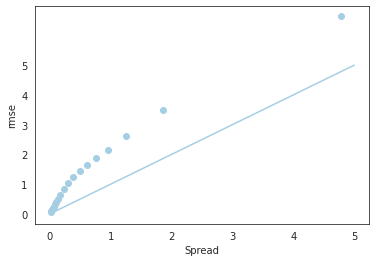

(16253, 100, 100, 20)
(16253, 100, 100)


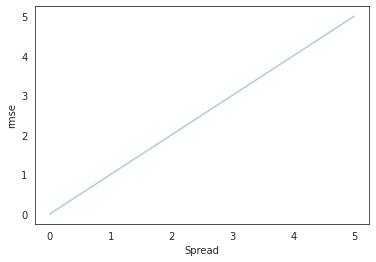

In [ ]:
rmse,rmss = spread_error(pred_ensemble_gan)

plt.scatter(rmss,rmse)
plt.xlabel('Spread')
plt.ylabel('rmse')
plt.xticks([0,1,2,3,4,5])
plt.yticks([0,1,2,3,4,5])
plt.plot([0,1,2,3,4,5],[0,1,2,3,4,5])
plt.show()

rmse,rmss = spread_error(pred_ensemble_vaegan)

plt.scatter(rmss,rmse)
plt.xlabel('Spread')
plt.ylabel('rmse')
plt.xticks([0,1,2,3,4,5])
plt.yticks([0,1,2,3,4,5])
plt.plot([0,1,2,3,4,5],[0,1,2,3,4,5])
plt.show()

In [7]:
print(pred_ensemble_vaegan.shape)
pred_ensemble_vaegan = np.load('/user/home/al18709/work/vaegan_predictions_20/validation_pred-opt_improve.npy')
pred_ensemble_gan = np.load('/user/home/al18709/work/gan_predictions_20/validation_pred-opt_improve.npy')
print(pred_ensemble_vaegan.shape)

(16253, 100, 100, 20)
(16253, 100, 100, 20)


In [13]:
# https://www.jstor.org/stable/24914540?seq=2#metadata_info_tab_contents